<a href="https://colab.research.google.com/github/sheshank1436/GANS/blob/master/Gans_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import required libraries
import torch
import torch.optim as opt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
device = 'cuda'

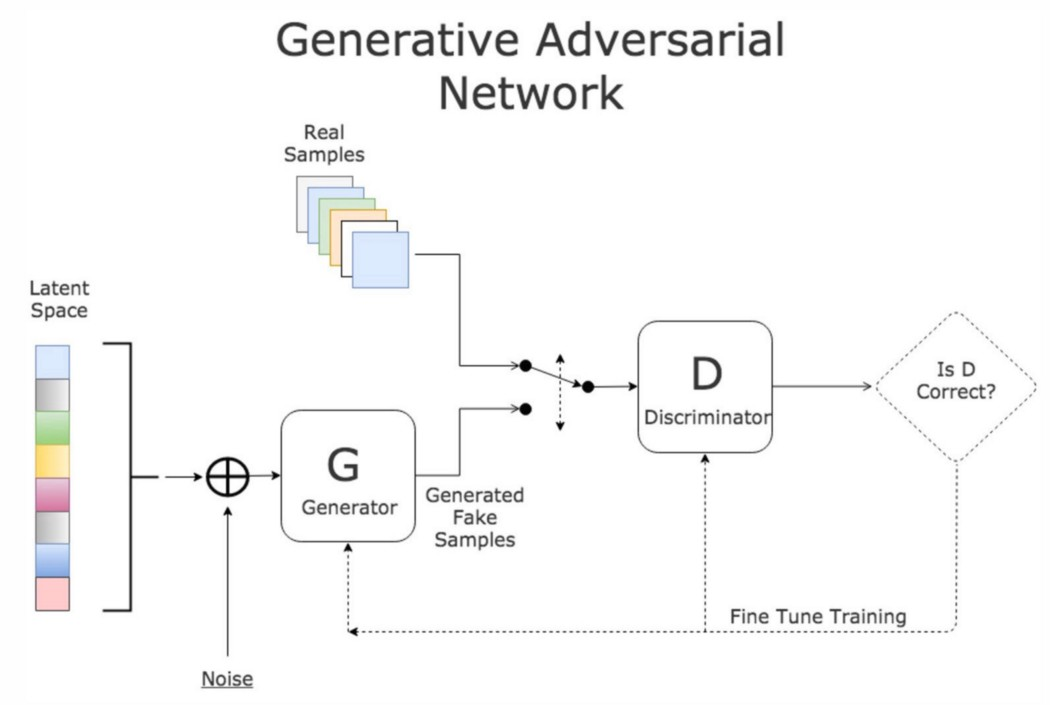

In [2]:
mb_size = 64
#converting to tensor
transform = transforms.ToTensor()
#downloading the training data of Mnist dataset
trainData = torchvision.datasets.MNIST('./data/', download=True, transform=transform, train=True)
#we need dataloader to load the data
trainLoader = torch.utils.data.DataLoader(trainData, shuffle=True, batch_size=mb_size)

In [21]:
dataIter = iter(trainLoader)

imgs, labels = dataIter.next()

In [40]:
def imshow(imgs):
    imgs = torchvision.utils.make_grid(imgs)
    npimgs = imgs.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()

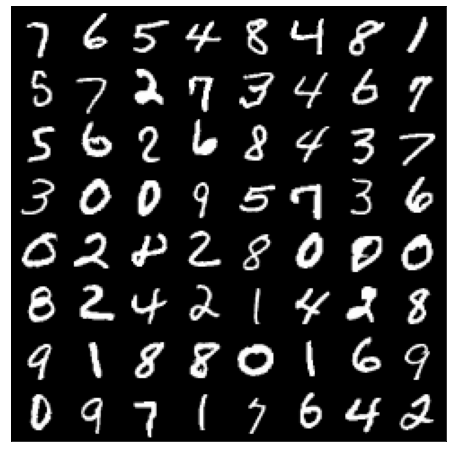

In [41]:
imshow(imgs)

In [4]:
#size(dimension) of the input noise vector which we pass to the generator
Z_dim = 100
#dimenions of hidden layers
hidden_dim = 128
#this is the  ouput dimensions of the generator network 
#since the mnist data images have shape of 28*28
im_dim = imgs.view(imgs.size(0), -1).size(1)

print(Z_dim, hidden_dim, im_dim)

device = 'cuda'

100 128 784


In [5]:
def get_generator_block(input_dim, output_dim):
    '''
    Function for returning a block of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with a linear transformation 
          followed by a batch normalization and then a relu activation
    '''
    return nn.Sequential(
         
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
        
    )

In [6]:
block = get_generator_block(25,12)
block

Sequential(
  (0): Linear(in_features=25, out_features=12, bias=True)
  (1): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)

In [17]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim, im_dim , hidden_dim ):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            
            # There is a dropdown with hints if you need them! 
            #### START CODE HERE ####
             
            nn.Linear(int(hidden_dim * 8), int(im_dim)),
            nn.Sigmoid()
           
        
            #### END CODE HERE ####
        )
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)
    
    # Needed for grading
    def get_gen(self):
        '''
        Returns:
            the sequential model
        '''
        return self.gen


In [30]:
G = Generator(Z_dim, im_dim, hidden_dim) 

In [19]:
print(G)

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=100, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


In [10]:
def get_discriminator_block(input_dim, output_dim):
     
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(0.2)
  
    )

In [34]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim , hidden_dim):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            # Hint: You want to transform the final output into a single value,
            #       so add one more linear map.
            #### START CODE HERE ####
            nn.Linear(int(hidden_dim),1),
            nn.Sigmoid()
           

           
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)
    
    # Needed for grading
    def get_disc(self):
        '''
        Returns:
            the sequential model
        '''
        return self.disc


In [35]:

D = Discriminator(im_dim,hidden_dim) 

In [36]:
for i, data in enumerate(trainLoader):
        #storing the batch features and labels in X,_
        X, _ = data
        # Flatten the batch of real images from the dataset
        X = X.view(X.size(0), -1)
        #below is the batch size we need to keep track of it because suppose we have 10 images in our dataset
        ##our batch size is 3 so in the last batch we have only 1 image 
        mb_size = X.size(0)
        #intialize one and zero labels
        one_labels = torch.ones(mb_size, 1) 
        zero_labels = torch.zeros(mb_size, 1) 
        #generating feedbacks for discriminator
        #randomly create a noise vector having dimensions(batchsize,input size to generator)
        z = torch.randn(mb_size, Z_dim) 
        #generate predictions for real images using the discriminator
        D_real = D(X)
        print(D_real)
        break

tensor([[0.5087],
        [0.5138],
        [0.5093],
        [0.5124],
        [0.5171],
        [0.5092],
        [0.5137],
        [0.5129],
        [0.5089],
        [0.5148],
        [0.5134],
        [0.5129],
        [0.5066],
        [0.5082],
        [0.5121],
        [0.5136],
        [0.5095],
        [0.5128],
        [0.5127],
        [0.5116],
        [0.5111],
        [0.5091],
        [0.5088],
        [0.5147],
        [0.5074],
        [0.5150],
        [0.5122],
        [0.5112],
        [0.5115],
        [0.5117],
        [0.5078],
        [0.5091],
        [0.5098],
        [0.5137],
        [0.5117],
        [0.5106],
        [0.5087],
        [0.5154],
        [0.5143],
        [0.5141],
        [0.5153],
        [0.5146],
        [0.5144],
        [0.5148],
        [0.5109],
        [0.5118],
        [0.5093],
        [0.5122],
        [0.5078],
        [0.5128],
        [0.5147],
        [0.5141],
        [0.5157],
        [0.5139],
        [0.5138],
        [0

In [37]:
lr = 1e-3

g_opt = opt.Adam(G.parameters(), lr=lr)
d_opt = opt.Adam(D.parameters(), lr=lr)

Epoch:0,   G_loss:10.735980132495417,    D_loss:0.09959725605627733


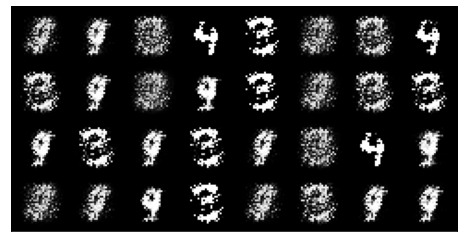

Epoch:1,   G_loss:8.523492081078894,    D_loss:0.13065831502874706


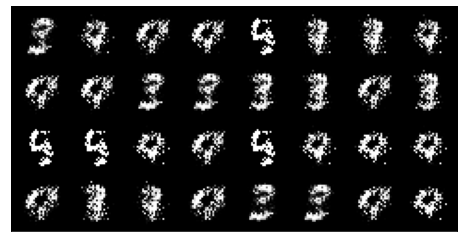

Epoch:2,   G_loss:7.451053914739124,    D_loss:0.18074948781512246


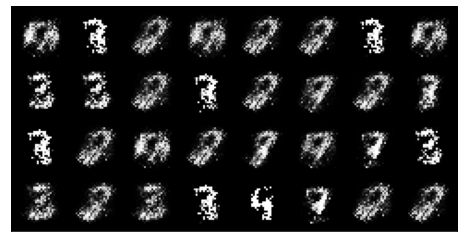

Epoch:3,   G_loss:6.947509171739061,    D_loss:0.254131395003395


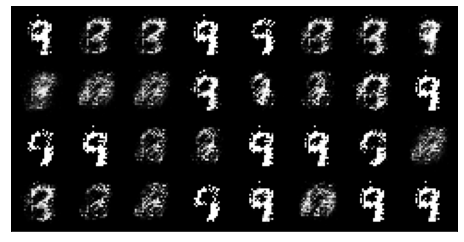

Epoch:4,   G_loss:5.34146883060683,    D_loss:0.2730249096609668


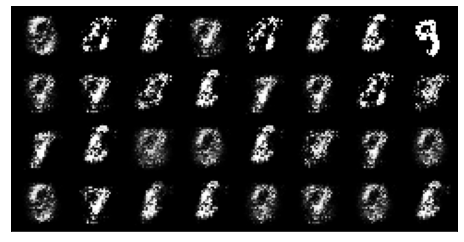

Epoch:5,   G_loss:5.670119090883462,    D_loss:0.27939956008579764


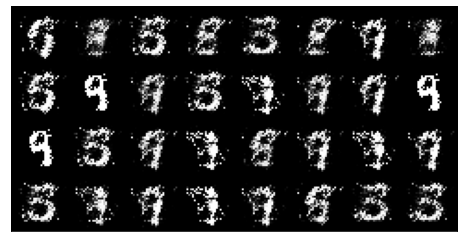

Epoch:6,   G_loss:4.762656258494615,    D_loss:0.2912985557940469


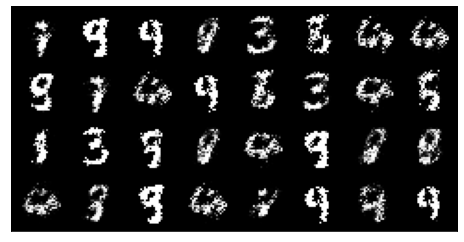

Epoch:7,   G_loss:4.87355156265088,    D_loss:0.35338803397408175


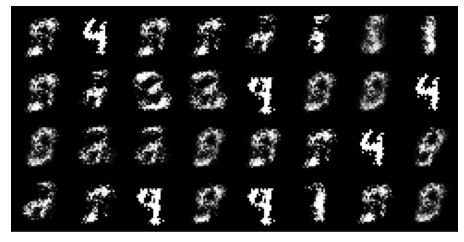

Epoch:8,   G_loss:4.76256815507722,    D_loss:0.29651725812475566


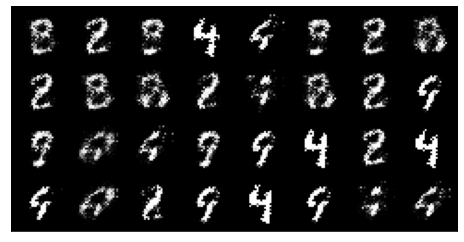

Epoch:9,   G_loss:4.759619536684521,    D_loss:0.31871105911039405


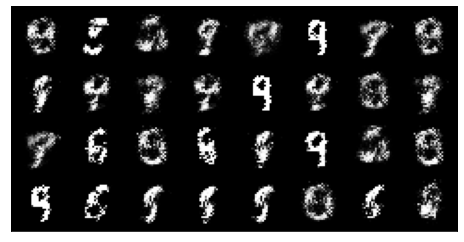

Epoch:10,   G_loss:4.6285021333043765,    D_loss:0.36514187218553856


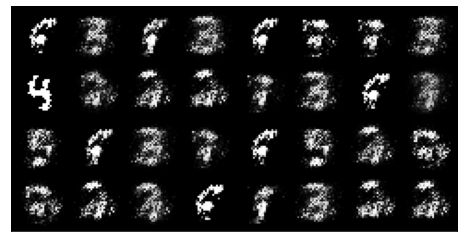

Epoch:11,   G_loss:3.93395663604045,    D_loss:0.42645018055701434


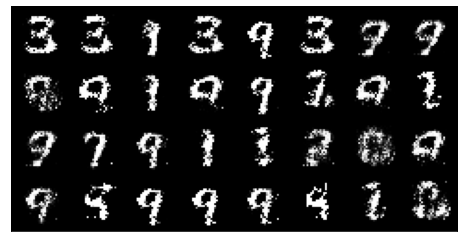

Epoch:12,   G_loss:4.44334028905897,    D_loss:0.3705535732479746


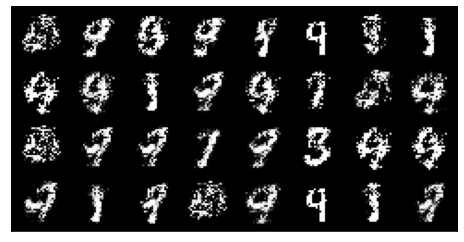

Epoch:13,   G_loss:4.063754365134087,    D_loss:0.4132468760140669


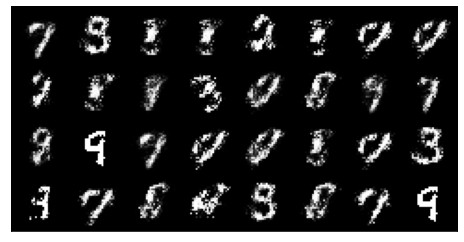

Epoch:14,   G_loss:3.998165431307323,    D_loss:0.4049656799416552


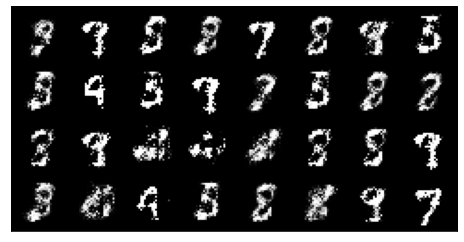

Epoch:15,   G_loss:3.800974724389343,    D_loss:0.43818079765989326


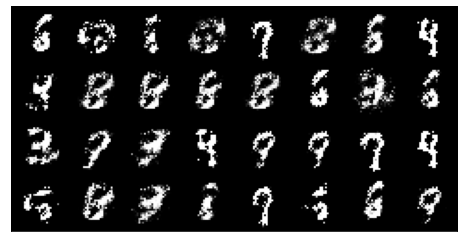

Epoch:16,   G_loss:3.816249144738163,    D_loss:0.43351076857875914


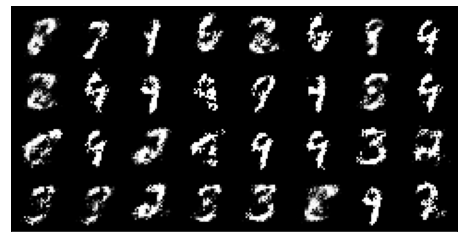

Epoch:17,   G_loss:3.557264149951528,    D_loss:0.460855593368697


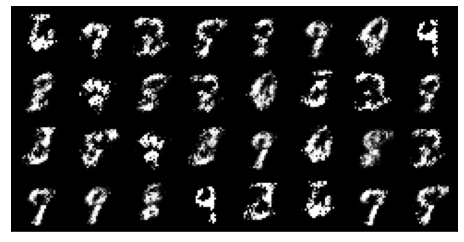

Epoch:18,   G_loss:3.1153906532950493,    D_loss:0.5068486485399926


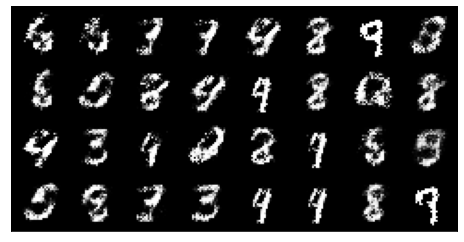

Epoch:19,   G_loss:3.213836300728926,    D_loss:0.5093389956363991


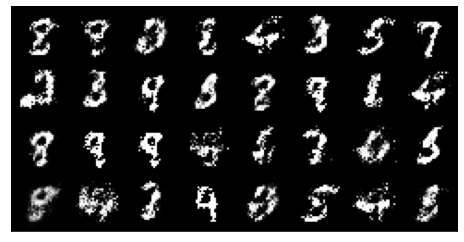

In [42]:
for epoch in range(20):
    G_loss_run = 0.0
    D_loss_run = 0.0
    #iterate through each batch of dataset using forloop for every epoch
    for i, data in enumerate(trainLoader):
        #storing the batch features and labels in X,_
        X, _ = data
        # Flatten the batch of real images from the dataset
        X = X.view(X.size(0), -1)
        #below is the batch size we need to keep track of it because suppose we have 10 images in our dataset
        ##our batch size is 3 so in the last batch we have only 1 image 
        mb_size = X.size(0)
        #intialize one and zero labels
        one_labels = torch.ones(mb_size, 1) 
        zero_labels = torch.zeros(mb_size, 1) 
        #generating feedbacks for discriminator
        #randomly create a noise vector having dimensions(batchsize,input size to generator)
        z = torch.randn(mb_size, Z_dim) 
        #generate predictions for real images using the discriminator
        D_real = D(X)
        #generate the fake images with generator using the noise vector as input
        #Get the discriminator's prediction of the fake image.
        D_fake = D(G(z))
        #calculate the loss of real images comparing with one_labels
        D_real_loss = F.binary_cross_entropy(D_real, one_labels)
        #calculate the loss of fake images comparing with zero_labels
        #here we use zero labels because fake=0 and real=1 for discriminator
        D_fake_loss = F.binary_cross_entropy(D_fake, zero_labels)
        #average the total loss
        D_loss = (D_real_loss + D_fake_loss)
        #make the gradients zero
        d_opt.zero_grad()
        D_loss.backward()
        #update the gradients
        d_opt.step()


        #feedback for generator
        #randomly create a noise vector having dimensions(batchsize,input size to generator)
        z = torch.randn(mb_size, Z_dim) 
        #generate the fake images with generator using the noise vector as input
        #Get the discriminator's prediction of the fake image.
        D_fake = D(G(z))
        #calculate the loss of fake images comparing with one_labels
        #here we use one_labels because we need to make the fake images as real as possible and bring gen values close to 1
        G_loss = F.binary_cross_entropy(D_fake, one_labels)
        
        g_opt.zero_grad()
        G_loss.backward()
        g_opt.step()
        #update losses
        
        G_loss_run += G_loss.item()
        D_loss_run += D_loss.item()
        
    print('Epoch:{},   G_loss:{},    D_loss:{}'.format(epoch, G_loss_run/(i+1), D_loss_run/(i+1)))
    
    samples = G(z).detach()
    samples = samples.view(samples.size(0), 1, 28, 28).cpu()
    imshow(samples)